# Grundlagen der Künstlichen Intelligenz - Wintersemester 2025/26


# Übung 2: Regression und Klassifikation mit linearen Modellen

---

> **Grundlagen der künstlichen Intelligenz** im Wintersemester 2025/2026
>
> - Prof. Pascal Friederich, pascal.friederich@kit.edu
> - T.T.-Prof. Peer Nowack, peer.nowack@kit.edu
>
> Übungsleiter für die aktuelle Übung: Jonas Teufel, jonas.teufel@kit.edu
>
> ⚠️ Bei allgemeinen Fragen zu Aufgabenstellungen etc. bitte im Ilias Forum posten, sodass wir diese Fragen nur ein Mal für alle Studierenden beantworten können. E-Mail an den Übungsleiter bitte nur für individuelle Fragen, deren Beantwortung nicht für alle Studierenden relevant ist.

---

- **Wir nutzen ein automatisiertes Grading System zur Bewertung der Jupyter Notebooks (siehe unten für Details)**
- **Bitte ladet dieses Übungsblatt daher bei Ilias als Abgabe hoch, auch wenn ihr es nur teilweise (oder gar nicht!) bearbeitet habt.**
- **Auf diese Weise könnt ihr technische Probleme beim Grading finden und wir können sie gemeinsam in der ersten Saalübung lösen.**
- **Ab dem zweiten Übungsblatt erwarten wir, dass die technischen Probleme gelöst sind.**
- **Nutzt daher bitte diese Möglichkeit!**

### Übungsteam

- Mozhgan Amiramjadi, mozhgan.amjadi@kit.edu
- Lina Rennstich, lina.rennstich@kit.edu
- Ulrich Oberhofer, ulrich.oberhofer@kit.edu
- Laura Ruple, laura.ruple@kit.edu
- Henrik Schopmans, henrik.schopmans@kit.edu
- Jonas Teufel, jonas.teufel@kit.edu

# Gruppenabgabe

Die Übungsblätter können in Gruppen von bis zu **3 Studierenden** abgegeben werden. **Jede Person aus der Gruppe muss die finale Version der Abgabe über Ilias hochladen**, es genügt nicht, dass nur eine Person aus der Gruppe dies tut. Es ist prinzipiell möglich, im Laufe des Semesters sich einer neuen Gruppe anzuschließen, sollte sich die eigene Gruppe vorzeitig auflösen. Generell muss jede Gruppe ihre eigene Lösung hochladen, wir werden die Abgaben auf Duplikate überprüfen.

Die Gruppen werden automatisch erfasst, **gebt deshalb die u-Kürzel eurer Gruppenmitglieder in die folgende Zelle ein.** Falls eure Gruppe nur aus 2 Studierenden besteht, oder ihr alleine abgibt, lasst die verbleibenden Felder frei. Hier ein Beispiel für eine Gruppe bestehend aus uabcd und uefgh:

_U-Kürzel der Gruppenmitglieder:_

_Mitglied 1: uabcd_

_Mitglied 2: uefgh_

_Mitglied 3:_


U-Kürzel der Gruppenmitglieder:

Mitglied 1: ubrfu

Mitglied 2: uysax

Mitglied 3: udxde


# Auto-grading

Wir nutzen ein auto-grading System, welches eure abgegebenen Jupyter Notebooks automatisch analysiert und über
hidden tests auf Richtigkeit prüft. Über diese Tests werden die Punkte bestimmt, die ihr für das Übungsblatt erhaltet.

Damit das auto-grading reibungslos funktioniert bitte folgende Dinge beachten:

- Notebook muss Dateinamen "ex_02_regression_classification.ipynb" haben
- PDF und Jupyter notebook einzeln im Ilias hochladen (nicht als Zip!)
- Vor dem Abgeben eines Notebooks bitte testen, dass alles von vorne bis hinten ohne Fehler durchläuft.
- Zellen, welche mit "##### DO NOT CHANGE #####" markiert sind dürfen weder gelöscht noch bearbeitet werden
- Eure Lösung muss in die richtige Zelle (markiert mit "# YOUR CODE HERE") eingetragen werden.
  - (dabei natürlich den NotImplementedError löschen!)
- Es gibt potentiell scheinbar leere Zellen, die auch mit "" markiert sind. Auch diese dürfen nicht bearbeitet oder gelöscht werden.
  - Falls dies doch gemacht wird, dann wird das automatische Grading nicht funktionieren und ihr erhaltet keine Punkte.
  - Wir werden hier strikt handeln und keine Ausnahmen machen, falls jemand doch Zellen verändert, die eindeutig als readonly markiert sind!
- Die Jupyter Notebooks haben inline Tests (für euch sichtbar), welche euer Ergebnis auf grobe Richtigkeit überprüfen.
  - Diese sind primär für euch, um Fehler zu erkennen und zu korrigieren.
  - Die inline Tests, die ihr im Notebook sehen könnt, sind allerdings nicht die Tests welche für das Grading verwendet werden!
  - Die inline Tests sind eine notwendige aber keine hinreichende Bedingung, um beim Grading der Aufgabe Punkte zu erhalten!


In [60]:
##### DO NOT CHANGE #####
import io
import requests

import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    f1_score,
)


def nextcloud_download(url: str) -> str:
    """
    Downloads the *content* of a file from a nextcloud server.

    :param url: the absolute URL of the file on the nextcloud server

    :returns: the string content of the file
    """
    if not url.endswith('/download'):
        url += '/download'

    response = requests.get(url)
    content = response.content.decode('utf-8')

    return content


sns.set(style="whitegrid")

##### DO NOT CHANGE #####

# **2.1** $\cdot$ *Regression*

**Regression.** In diesem ersten Teil der Aufgabe befassen wir uns mit der Regressionsaufgabe - d.h. der Suche nach einer linearen Funktion welche eine gegebene Funktion $f: \mathbb{R}^N \rightarrow \mathbb{R}, \mathbf{x} \mapsto y$ so gut wie möglich approximiert. Im Normalfall haben wir dabei keinen Zugang zur analytischen Form dieser Funktion, sondern beziehen unser einziges Wissen von einem Datensatz bestehend aus konkreten *Samples* dieser Funktion. Wir können diese Samples nutzen im ein *Modell* der Funktion zu erstellen, welches diese hoffentlich bestmöglich annähert.

**Train-Test Aufteilung.** Das Ziel ist also eine solche Funktion $\hat{f}: \mathbb{R}^N \rightarrow \mathbb{R}, \mathbf{x} \mapsto \hat{y}$ zu finden welche den (quadratischen) Fehler zur tatsächlichen Funktion minimiert:

$$
\min_{\mathbf{x} \in \mathcal{X}} \; (\hat{f}(\mathbf{x}) - f(\mathbf{x}))^2
$$

Da wir $f(x)$ aber nicht an beliebiger Stelle evaluieren können, geschieht diese Minimierung in der Praxis nur über eine bekannte und endliche Menge an  Eingabewerten $\mathcal{X}$. Nutzt man hierfür ein ausreichend komplexes Modell wäre es möglich für beliebig große Datenmenge einen Fehler von 0 zu erreichen (man Stelle sich zum Beispiel einen Lookup Table bzw. eine lineare Interpolation über alle bekannten Punkte vor). Ein solches Modell wäre aber höchstwahrscheinlich nicht zielführend um den Funktionswert von zukünftigen unbekannten Punkten vorherzusagen, da jeglicher Einfluss von Messrauschen etc. in ein solches Modell miteinfließt. Daher benötigt man eine sinnvollere Möglichkeit die Eignung eines Modells zu bewerten als den direkten Approximations-Fehler zu minimieren. In der Praxis erreicht man dies indem man die vorhandenen Daten aufteilt in einen Trainings- und einen Testdatensatz. Die Optimierung der Modellparameter findet dann ausschließlich auf den Trainingsdaten statt. Anschließend wird die Qualität des Modells über den Approximations-Fehler auf den Test Daten bewertet. Die Argumentation ist folgende: Nur wenn das Modell durch die Trainingsdaten die *wahre Funktion* approximiert, sollte es auch dementsprechend gute Vorhersagen für die Testdatenpunkte liefern - auch ohne explizit auf diesen optimiert worden zu sein.

**Beispiel Funktion.** Die nachfolgende Zelle definiert zunächst eine beispielhafte Funktion welche im Folgenden als *wahre Funktion* zu Grunde gelegt wird. Daraufhin erstellen wir einen Trainings- und Testdatensatz indem wir konkrete Punkte von dieser Funktion sampeln.

In [61]:
##### DO NOT CHANGE #####
def true_function_2d(
    t: np.ndarray
) -> np.ndarray:
    """
    The true function to be approximated. Takes as input a 2D array of shape
    (N, 2) and returns the function value of shape (N, 1).

    Parameters:
        t : np.ndarray
            Input array of shape (..., 2) containing x and y coordinates.

    Returns:
        np.ndarray
            Function values of shape (..., 1) computed from the input coordinates.
    """
    x = t[..., 0]
    y = t[..., 1]

    result = (
        0.5 * x**4 - 1.5 * x**2 + 2 * x +
        3 * (y + x) - 0.5 * (x + y)**2 +
        4
    )
    # Return with shape (..., 1) for consistency with predict_regressor output
    return result[..., np.newaxis]

# --- generating a dataset ---

def sample_dataset_2d(
    n_samples: int,
    noise_std: float = 1.0,
    random_state: int = 42,
    x_range: tuple = (-2, 2)
) -> tuple[np.ndarray, np.ndarray]:
    """
    Creates explicit samples of the `true_function_2d` by sampling uniformly within the
    given input value range `x_range` and adding Gaussian noise with standard deviation
    `noise_std` to the function values to emulate measurement noise.

    Parameters:
        n_samples : int
            Number of samples to generate.
        noise_std : float
            Standard deviation of the Gaussian noise to add to function values.
        random_state : int
            Random seed for reproducibility.
        x_range : tuple
            Range (min, max) for uniformly sampling input values.

    Returns:
        tuple[np.ndarray, np.ndarray]
            A tuple (x, y) where `x` is the input data of shape (n_samples, 2) and
            `y` are the corresponding noisy function values of shape (n_samples,).
    """
    rng = np.random.default_rng(random_state)
    x = rng.uniform(x_range[0], x_range[1], size=(n_samples, 2))
    # true_function_2d now returns (n_samples, 1), so we need to flatten for consistency
    y = true_function_2d(x).ravel() + rng.normal(0, noise_std, size=n_samples)
    return x, y

# We generate a training and a test dataset
x_train_2d, y_train_2d = sample_dataset_2d(100, noise_std=0.5, random_state=0)
x_test_2d, y_test_2d = sample_dataset_2d(100, noise_std=0.5, random_state=1)

##### DO NOT CHANGE #####

**📊 Visualisierung.** Diese Zelle visualisiert die gegebene und zu approximierende Funktion. Die Wireframe-Darstellung sowie der projizierte Contour-Plot zeigen die Funktionswerte der wahren Funktion. Die blauen und orangen Punkte zeigen die von dieser Funktion gesampleten Trainings- und Testdatenpunkte, welche später für das Fitting und die Evaluation eines Regressionsmodells verwendet werden können.

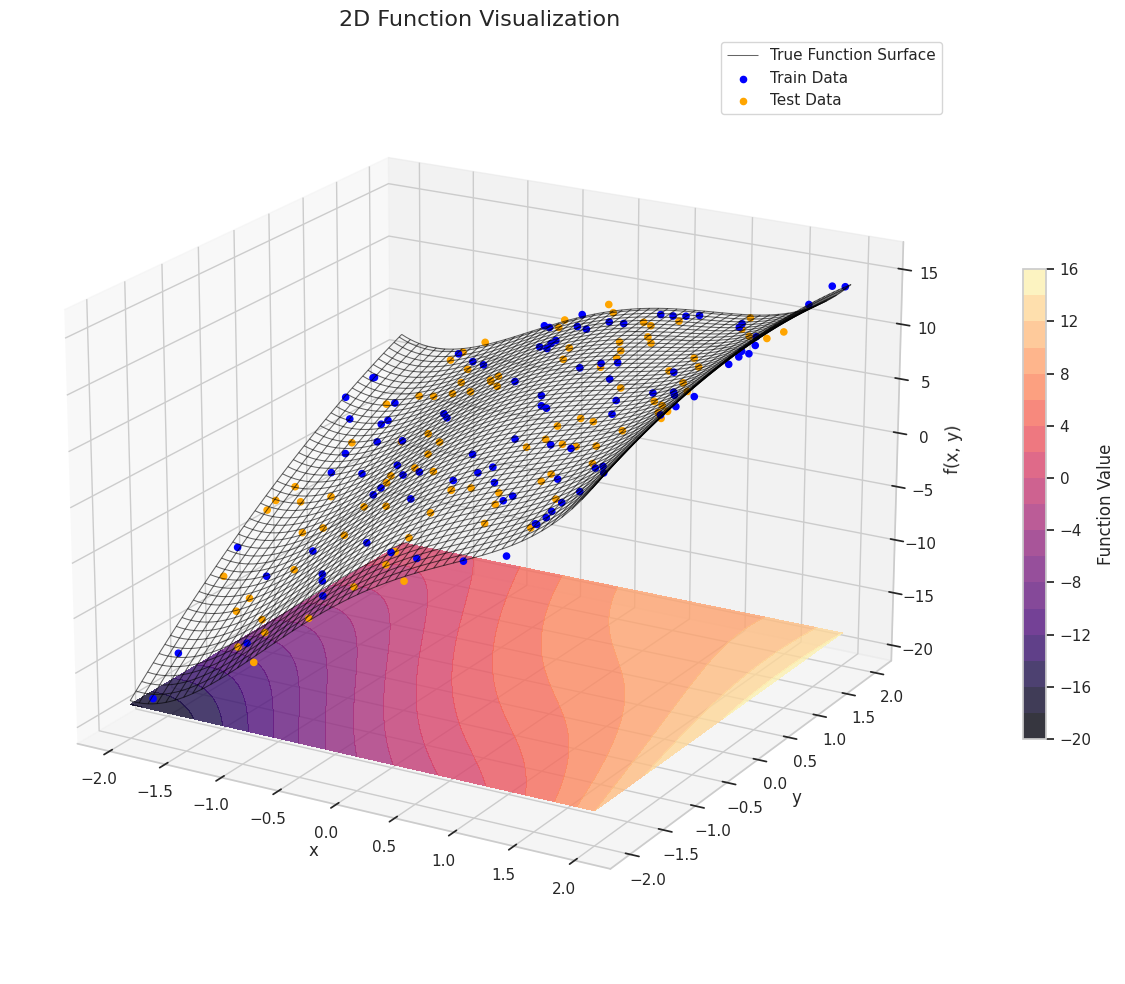

In [62]:
##### DO NOT CHANGE #####
# --- plotting the 2d function ---

val_min, val_max = -2, 2

# Create a grid for plotting the 2D function
x_grid = np.linspace(val_min, val_max, 100)
y_grid = np.linspace(val_min, val_max, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Create input array for the true_function_2d
grid_points = np.stack([X_grid, Y_grid], axis=-1)

# Evaluate the function on the grid
Z = true_function_2d(grid_points)

# Create a 3D plot with surface and 2D projection
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface as wireframe
wireframe = ax.plot_wireframe(X_grid, Y_grid, Z.squeeze(), alpha=0.6, color='black', linewidth=0.75, label='True Function Surface')

# Create the 2D heatmap projection at the bottom
# Get the z-limits to place the projection at the bottom
z_min = np.min(Z)
z_max = np.max(Z)
z_offset = z_min - (z_max - z_min) * 0.01  # Place projection slightly below minimum

# Plot the contour/heatmap at the bottom
contour = ax.contourf(X_grid, Y_grid, Z.squeeze(), levels=20, zdir='z', offset=z_offset, cmap='magma', alpha=0.8)

# Plot train and test data as scatter points
ax.scatter(x_train_2d[:, 0], x_train_2d[:, 1], y_train_2d, c='blue', s=20, alpha=1., label='Train Data', zorder=100)
ax.scatter(x_test_2d[:, 0], x_test_2d[:, 1], y_test_2d, c='orange', s=20, alpha=1., label='Test Data', zorder=100)

# Add a colorbar
fig.colorbar(contour, ax=ax, shrink=0.5, aspect=20, label='Function Value')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('2D Function Visualization', fontsize=16)

# Add legend
ax.legend()

# Adjust the viewing angle for better visualization
ax.view_init(elev=20)

plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

## **2.1.1** $\cdot$ *Grundlagen der Linearen Regression*

Im Folgenden wollen wir eine linear Regression selbst implementieren. Für ein lineares Regressions Modell suchen wir nach einem Gewichtsvektor $\mathbf{w}$ welcher mit den Eingangsdaten $\mathbf{x}$ multipliziert die gesuchte Funktion $y = f(\mathbf{x})$ approximiert:

$$
y_{pred} = \mathbf{w} \cdot \begin{pmatrix}
\mathbf{x} \\ 1
\end{pmatrix}
$$

Durch eine explizite Optimierung der Summed Squared Error (SSE) finden wir eine analytische Lösung für den gesuchten Gewichtsvektor $\mathbf{w}$. Diesen können wir nämlich - wie aus der Vorlesung bekannt - über eine Pseudo-Inverse der Trainingsdaten $\mathbf{X}$ multipliziert mit den korrespondierenden Funktionswerten $\mathbf{y}$ bestimmen:

$$
\begin{align}
\mathbf{w} &= \mathbf{X}^{\dagger} \cdot \mathbf{y} \\
\mathbf{w} &= (\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T \cdot \mathbf{y}
\end{align}
$$

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.1 (2 Punkte).</strong> Implementiere die unten stehende Funktionen <code>fit_regressor</code>. Diese Funktion soll einen Vektor <code>x</code> an Trainingsdaten und deren korrespondierende Funktionswerte <code>y</code> als Funktionswerte entgegennehmen und den entsprechenden Gewichtsvektor zurückgeben. <em>Hinweis 1: </em> Der berechnete Gewichtsvektor soll auch ein Gewicht für den konstanten Bias Term enthalten! <em>Hinweis 2: </em> Stelle sicher dass die Funktion mit Daten verschiedener Dimensionalität (verschiedene Anzahl an Eingabewerten x) umgehen kann!
</div>

In [63]:
def fit_regressor(x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Fit a linear regression model to the training data `x` of shape (n_samples, n_features)
    and y of shape (n_samples, 1) using the ordinary least squares method.
    Return the weight vector `w` of shape (n_features + 1, 1) including the bias term.

    Parameters:
        x : np.ndarray
            Input features of shape (n_samples, n_features).
        y : np.ndarray
            Target values of shape (n_samples, 1).

    Returns:
        w : np.ndarray
            Weight vector of shape (n_features + 1, 1) including the bias term.
    """
    # YOUR CODE HERE
    # Make y a column vector
    if y.ndim == 1:
      y = y.reshape(-1, 1)

    n_samples = x.shape[0]

    # Add bias
    X_aug = np.hstack([np.ones((n_samples, 1)), x])

    # Calculat X using the pseudo-inverse equation
    w = la.inv(X_aug.T @ X_aug) @ (X_aug.T @ y)

    return w

In [64]:
##### DO NOT CHANGE #####
# ID: task-2-1-fit-reg - possible points: 2

# --- testing output shape for 2D function ---
x_test_1 = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 3]])
y_test_1 = np.array([[1], [2], [3], [4], [2]])
w_test_1 = fit_regressor(x_test_1, y_test_1)
print('w_test_1', w_test_1)
assert isinstance(w_test_1, np.ndarray)
assert w_test_1.shape == (3, 1)

# --- testing output shape for 1D function ---
x_test_2 = np.array([[0], [1], [2], [3], [4]])
y_test_2 = np.array([[1], [2], [3], [4], [2]])
w_test_2 = fit_regressor(x_test_2, y_test_2)
print('w_test_2', w_test_2)
assert isinstance(w_test_2, np.ndarray)
assert w_test_2.shape == (2, 1)

# --- hidden tests ---
# The hidden tests will check for the correctness of the approximation with some sample
# data


##### DO NOT CHANGE #####

w_test_1 [[0.5]
 [1. ]
 [0.5]]
w_test_2 [[1.6]
 [0.4]]


<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.2 (2 Punkte).</strong> Implementiere die unten stehende Funktion <code>predict_regressor</code>. Diese Funktion soll einen Vektor <code>x</code> an Eingangsdaten und eine zuvor berechneten Gewichtsvektor <code>w</code> entgegennehmen und die approximierten Funktionswerte <code>y_pred</code> zurückgeben. <em>Hinweis: </em> Stelle sicher dass die Funktion mit Daten verschiedener Dimensionalität (verschiedene Anzahl an Eingabewerten x) umgehen kann!
</div>

In [65]:
def predict_regressor(x: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Predict the target values for the input data `x` of shape (n_samples, n_features)
    using the weight vector `w` of shape (n_features + 1, 1).

    Parameters:
        x : np.ndarray
            Input features of shape (n_samples, n_features),
            which *do not include* the bias term!
        w : np.ndarray
            Weight vector of shape (n_features + 1, 1) including the bias term.

    Returns:
        y_pred : np.ndarray
            Predicted target values of shape (n_samples, 1).
    """
    # YOUR CODE HERE
    # Make sure x is 2D
    if x.ndim == 1:
      x = x.reshape(1, -1)

    n_samples = x.shape[0]

    # Add bias
    X_aug = np.hstack([np.ones((n_samples, 1)), x])

    y_pred = X_aug @ w

    return y_pred

In [66]:
##### DO NOT CHANGE #####
# ID: task-2-2-predict-reg - possible points: 2

# --- testing output shape for 2D function ---
x_test_1 = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 3]])
w_test_1 = np.array([[1], [2], [3]])
y_pred_1 = predict_regressor(x_test_1, w_test_1)
print('y_pred_1', y_pred_1)
assert isinstance(y_pred_1, np.ndarray)
assert y_pred_1.shape == (5, 1)

# --- testing output shape for 1D function ---
x_test_2 = np.array([[0], [1], [2], [3], [4]])
w_test_2 = np.array([[1], [2]])
y_pred_2 = predict_regressor(x_test_2, w_test_2)
print('y_pred_2', y_pred_2)
assert isinstance(y_pred_2, np.ndarray)
assert y_pred_2.shape == (5, 1)

# --- hidden tests ---
# The hidden tests will check for the correctness of the approximation with some sample
# data



##### DO NOT CHANGE #####

y_pred_1 [[ 4.]
 [ 6.]
 [ 8.]
 [10.]
 [10.]]
y_pred_2 [[1.]
 [3.]
 [5.]
 [7.]
 [9.]]


Mit dieser Implementierung der linearen Regression können wir nun ein Modell für unsere initiale 2-dimensionale Funktion erstellen. Hierzu "trainieren" wird das Modell auf den gesampleten Trainingsdatenpunkten und evaluieren danach den Fehler auf den Trainings- und Testdatenpunkten.

In [67]:
##### DO NOT CHANGE #####
w_2d = fit_regressor(x_train_2d, y_train_2d)
print('weights', w_2d)

y_train_pred = predict_regressor(x_train_2d, w_2d)
mse_train = mean_squared_error(y_train_2d, y_train_pred)
print('MSE on train data:', mse_train)

y_test_pred = predict_regressor(x_test_2d, w_2d)
mse_test = mean_squared_error(y_test_2d, y_test_pred)
print('MSE on test data:', mse_test)


##### DO NOT CHANGE #####

weights [[2.3886251 ]
 [4.69904443]
 [2.78820302]]
MSE on train data: 2.5911997782471197
MSE on test data: 2.2917279579038485


**📊 Visualisierung.** Der folgende Plot visualisiert die durch die lineare Regression approximierte Funktion (rote Wireframe) im Vergleich zur wahren Funktion (schwarze Wireframe). Der auf den Boden projizierte Contour-Plot zeigt auf wie groß der Approximationsfehler an der korrespondierenden Stelle ist.



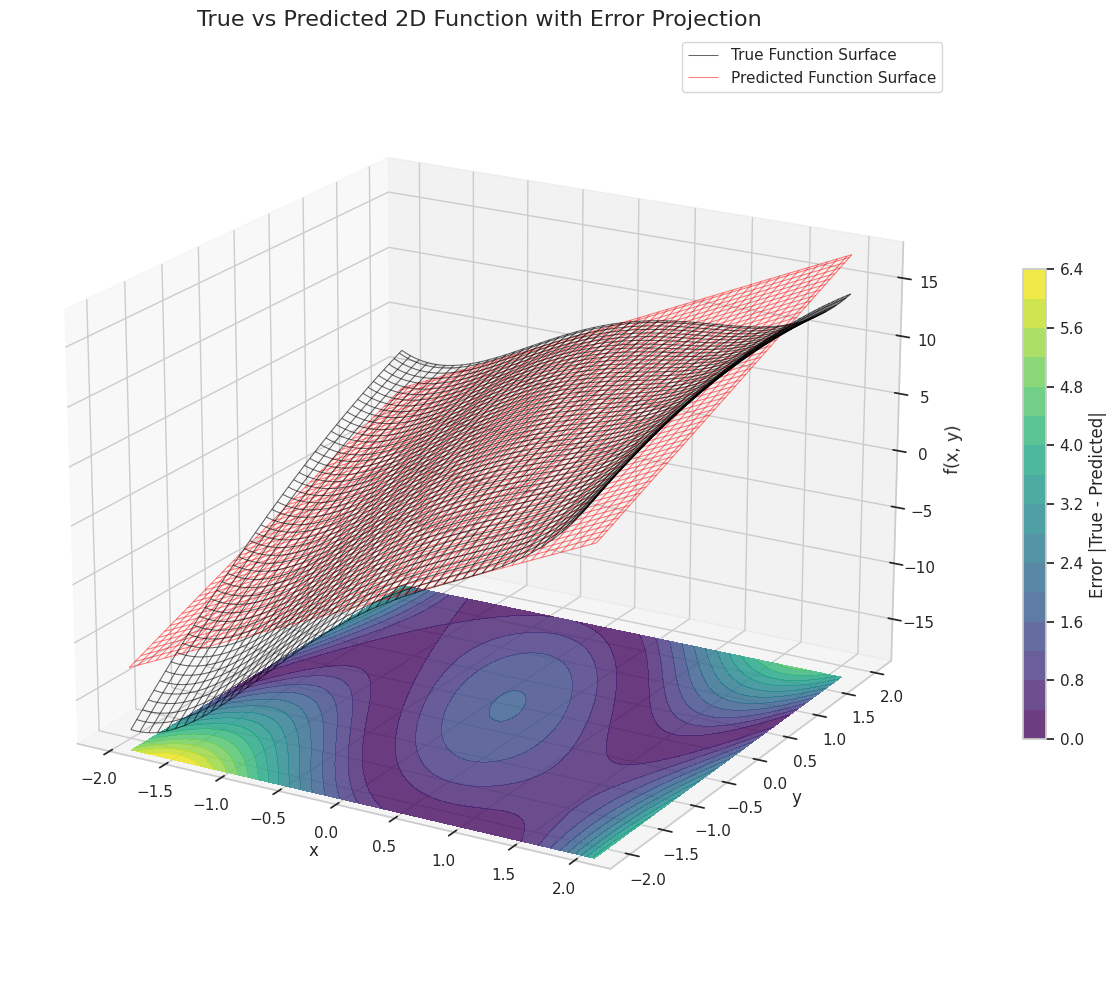

In [68]:
##### DO NOT CHANGE #####
# --- plotting the error between prediction and true function ---

# Use the same grid as in the original plot
val_min, val_max = -2, 2
x_grid = np.linspace(val_min, val_max, 100)
y_grid = np.linspace(val_min, val_max, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Create input array for the functions
grid_points = np.stack([X_grid, Y_grid], axis=-1)

# Calculate true function values
Z_true = true_function_2d(grid_points).squeeze()  # Remove singleton dimension for plotting

# Calculate predicted function values using the trained linear regression model
grid_points_reshaped = grid_points.reshape(-1, 2)
Z_pred = predict_regressor(grid_points_reshaped, w_2d).reshape(X_grid.shape)

# Calculate error between true and predicted functions
Z_error = np.abs(Z_true - Z_pred)

# Create a 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the true function as gray wireframe
wireframe_true = ax.plot_wireframe(X_grid, Y_grid, Z_true, alpha=0.6, color='black',
                                  linewidth=0.75, label='True Function Surface')

# Plot the predicted function as red wireframe
wireframe_pred = ax.plot_wireframe(X_grid, Y_grid, Z_pred, alpha=0.5, color='red',
                                  linewidth=0.75, label='Predicted Function Surface')

# Create the error projection at the bottom using viridis colormap
z_min = np.min([np.min(Z_true), np.min(Z_pred)])
z_max = np.max([np.max(Z_true), np.max(Z_pred)])
z_offset = z_min - (z_max - z_min) * 0.05  # Place projection slightly below minimum

# Plot the error contour/heatmap at the bottom
contour = ax.contourf(X_grid, Y_grid, Z_error, levels=20, zdir='z', offset=z_offset,
                     cmap='viridis', alpha=0.8)

# Add a colorbar for the error
cbar = fig.colorbar(contour, ax=ax, shrink=0.5, aspect=20, label='Error |True - Predicted|')

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('True vs Predicted 2D Function with Error Projection', fontsize=16)

# Add legend
ax.legend()

# Adjust the viewing angle for better visualization
ax.view_init(elev=20)

plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

## **2.1.2** $\cdot$ *Nicht-Lineare Regression und Generalisierung*

Im Folgenden beschäftigen wir uns mit der Polynom Regression als eine Erweiterung der linearen Regression. Hierzu definieren wir wieder eine wahre Funktion welche wir mit einem Modell approximieren wollen. Dieses Mal handelt es sich der Anschaulichkeit halber um eine 1-dimensionale Funktion.

In [69]:
##### DO NOT CHANGE #####
def true_function_1d(x: float | np.ndarray) -> float | np.ndarray:
    """
    A polynomial function to be approximated by regression models.
    Works with both scalar inputs and numpy arrays.

    Parameters:
        x : float or np.ndarray
            Input value(s). Can be a scalar or array of shape (N,).

    Returns:
        float or np.ndarray
            Function value(s) computed as 0.5*x^4 - 1.5*x^2 + 2*x + 3.
            Returns same type as input (scalar returns scalar, array of shape (N,) returns array of shape (N,)).
    """
    return 0.5*x**4 - 1.5 * x**2 + 2*x + 3


# --- generating a dataset ---

def generate_dataset_1d(
    num_samples: int = 100,
    noise_std: float = 0.5,
    x_range: tuple = (-1.0, +1.0),
    seed: int = 42,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Generates a dataset by sampling from `true_function_1d` and adding Gaussian noise.

    Parameters:
        num_samples : int
            Number of data points to generate.
        noise_std : float
            Standard deviation of Gaussian noise to add to function values.
        x_range : tuple
            Range (min, max) from which to uniformly sample x values.
        seed : int
            Random seed for reproducibility.

    Returns:
        tuple[np.ndarray, np.ndarray]
            A tuple (xs, ys_noisy) where `xs` contains the sampled x values and
            `ys_noisy` contains the corresponding noisy function values.
    """

    # Using a seeded RNG object will make sure that any subsequent random operations will be based on pseudo-random
    # numbers which will look random but will be reproducible if the same seed is used again.
    rng = np.random.default_rng(seed=seed)

    # Then we sample a bunch of x values uniformly from the specified range and compute the corresponding true values
    # using the true_function.
    xs = rng.uniform(x_range[0], x_range[1], size=num_samples)
    ys = true_function_1d(xs)
    # To simulate real-world data, we add Gaussian noise to these true values.
    ys_noisy = ys + rng.normal(0, noise_std, size=ys.shape)

    return xs, ys_noisy


X_MIN, X_MAX = -1.6, +1.6

x_train_1d, y_train_1d = generate_dataset_1d(
    num_samples=20,
    noise_std=0.5,
    seed=0,
    x_range=(X_MIN, X_MAX)
)
x_test_1d, y_test_1d = generate_dataset_1d(
    num_samples=20,
    noise_std=0.5,
    seed=1,
    x_range=(X_MIN, X_MAX)
)

##### DO NOT CHANGE #####

**📊 Visualisierung.** Der unten zu generierte Plot zeigt die wahre, zu approximierende Funktion gestrichelt im Hintergrund und die davon gesampleten Trainings- und Testdatenpunkte in blau bzw. orange. In diesem Fall gehen wir davon aus dass die Datenpunkte mit etwas mehr Messrauschen generiert werden.

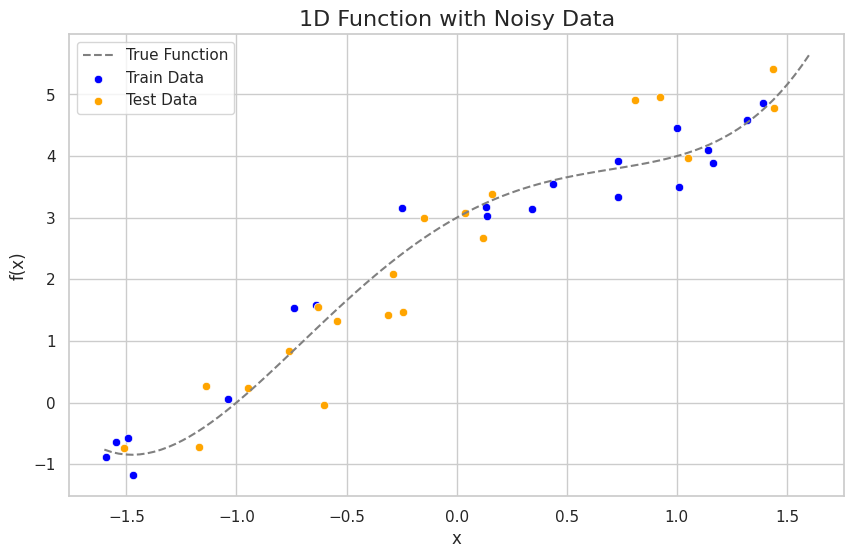

In [70]:
##### DO NOT CHANGE #####
xs_true = np.linspace(X_MIN, X_MAX, 100)
ys_true = true_function_1d(xs_true)

plt.figure(figsize=(10, 6))
plt.plot(xs_true, ys_true, label="True Function", color="gray", ls='--')
sns.scatterplot(x=x_train_1d, y=y_train_1d, label="Train Data", color="blue")
sns.scatterplot(x=x_test_1d, y=y_test_1d, label="Test Data", color="orange")

plt.xlabel('x')
plt.ylabel('f(x)')

plt.title('1D Function with Noisy Data', fontsize=16)
plt.show()

##### DO NOT CHANGE #####

**Scikit Learn.** Zunächst wollen wir als Baseline wieder ein lineares Regressions Modell fitten. Hierzu könnten wir unsere bereits implementierte eigene Funktion verwenden. Viele grundlegende Funktionen des Machine Learning müssen allerdings nicht immer wieder re-implementiert werden da sie schon in der `scikit-learn` Bibliothek enthalten sind, welche wir in diesem Fall benutzen wollen. Die Bibliothek stellt Implementationen für viele der gängigen Machine Learning Modelle bereit, darunter auch lineare Regression, Decision Trees, Random Forests, Neural Networks und Vieles mehr.

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.3 (1 Punkte).</strong> Initialisiere eine neue Instanz des <code>LinearRegression</code> Modells in der unten angegebenen Variable <code>model</code> und nutze die <code>fit</code> Funktion um das Modell auf den gegebenen Trainingsdaten zu fitten.
</div>

In [71]:
model: LinearRegression = None

# YOUR CODE HERE
model = LinearRegression()
x_train = x_train_1d.reshape(-1, 1)
y_train = y_train_1d
model.fit(x_train, y_train)

LinearRegression()

In [72]:
##### DO NOT CHANGE #####
# ID: task-2-3-sklearn-reg - possible points: 1

# --- checking type ---
assert model is not None, "You have to initialize the model variable with a LinearRegression model and fit it on the training data."
assert isinstance(model, LinearRegression), "The model variable has to be of type LinearRegression."
assert hasattr(model, "coef_"), "The model has not been fitted yet. Please fit the model on the training data."

# --- hidden tests ---
# Checking if the model is fitted correctly by evaluating its performance on the test set


##### DO NOT CHANGE #####

 * MSE on the test set: 0.3667


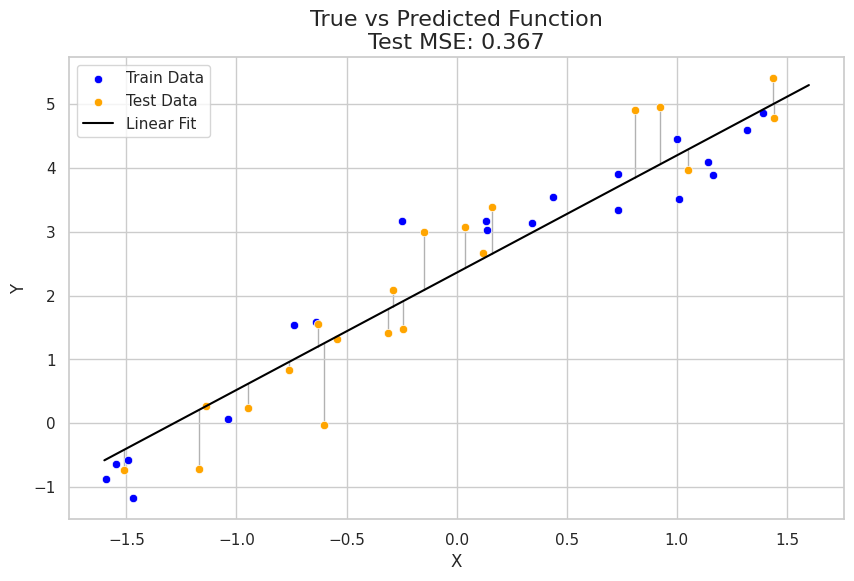

In [73]:
##### DO NOT CHANGE #####
# --- model evaluation on test set ---
# Evaluate the trained model on the test set
ys_pred = model.predict(x_test_1d.reshape(-1, 1))
mse_value = mean_squared_error(y_test_1d, ys_pred)
print(f' * MSE on the test set: {mse_value:.4f}')

# --- visualization preparation ---
# Generate predictions for the full range to create smooth line
x_true_1d = np.linspace(X_MIN, X_MAX, 100)
ys_pred_line = model.predict(x_true_1d.reshape(-1, 1))

# Calculate linear fit predictions for test data points (for vertical lines)
ys_pred_test_points = model.predict(x_test_1d.reshape(-1, 1))

# --- visualizing the linear fit ---
plt.figure(figsize=(10, 6))

# Plot training and test data points
sns.scatterplot(x=x_train_1d, y=y_train_1d, label="Train Data", color="blue")
sns.scatterplot(x=x_test_1d, y=y_test_1d, label="Test Data", color="orange")

# Plot the linear fit line
plt.plot(x_true_1d, ys_pred_line, label="Linear Fit", color="black")

# Add vertical lines from test data points to linear fit
for i, (x_test, y_test, y_pred_point) in enumerate(zip(x_test_1d, y_test_1d, ys_pred_test_points)):
    plt.plot(
        [x_test, x_test],
        [y_test, y_pred_point],
        color="gray",
        alpha=0.6,
        linestyle="-",
        linewidth=1,
        zorder=-10
    )

# Configure plot appearance
plt.xlabel("X")
plt.ylabel("Y")
plt.title(f"True vs Predicted Function\nTest MSE: {mse_value:.3f}", fontsize=16)
plt.legend()
plt.show()

##### DO NOT CHANGE #####

**Polynom Regression.** Nun wollen wir anstelle einer linearen Funktion eine polynomielle Funktion fitten. Im eindimensionalen Fall wollen wir bei der linearen Regression zwei Parameter $c_0, c_1$ fitten:

$$
y = c_1 \cdot x + c_0
$$

Für den verallgemeinerten Fall der Polynom-Regression wollen wir stattdessen die $k$ Gewichte der polynomiellen Terme fitten:

$$
y = c_k \cdot x^k + c_{k-1} \cdot x^{k-1} + \dots + c_1 \cdot x + c_0
$$

Wie wir in der Vorlesung gelernt haben lässt sich dieser Fall auf die linear Regression zurückführen indem wir einfach den Vektor der Eingangsdaten umdefinieren:

$$
\phi = \begin{pmatrix}
x^k & x^{k-1} & \dots & x & 1
\end{pmatrix} \\
y = \mathbf{w} \cdot \phi
$$

und dann diese erweiterten Eingangsdaten nutzen um die Gewichte mit Hilfe der Pseudo-Inversen zu finden:

$$
\mathbf{w} = (\Phi^T \Phi)^{-1} \Phi^T \cdot \mathbf{y}
$$



**Scikit Learn.** Auch hierfür stellt die `scikit-learn` Bibliothek bereits Funktionen bereit, welche wir im folgenden nutzen wollen. Als Startpunkt für eine Implementierung kann eine Internetsuche zu *"Sklearn Polynom Regression"* dienen.

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.4 (4 Punkte).</strong> Implementiere die untenstehende Funktion <code>fit_polynomial_model</code>. Diese soll die Eingangsdaten <code>x</code>, die korrespondierenden Funktionswerte <code>y</code> und den gewünschten Polynomgrad <code>degree</code> als Argumente akzeptieren. Basierend darauf soll eine bereits gefittete sklearn Instanz des Types <code>BaseEstimator</code> zurückgegeben werden. <em>Hinweis:</em> BaseEstimator ist keine instanzierbare Klasse und dient nur als abstrakte Grundklasse von der alle spezifischen Modellklassen erben.
</div>

In [74]:
def fit_polynomial_model(
    x: np.ndarray,
    y: np.ndarray,
    degree: int = 3,
) -> sklearn.base.BaseEstimator:
    """
    Fit a polynomial regression model of specified degree to the training data (x, y).

    Parameters:
        x : np.ndarray
            Input features of shape (n_samples, 1).
        y : np.ndarray
            Target values of shape (n_samples, 1).
        degree : int
            Degree of the polynomial features.

    Returns:
        model : BaseEstimator
            A scikit-learn estimator representing the fitted polynomial regression model.
    """
    # YOUR CODE HERE
    if x.ndim == 1:
      x = x.reshape(-1, 1)
    if y.ndim == 1:
      y = y.reshape(-1, 1)

    model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=degree, include_bias=True)),
        ("linear_regression", LinearRegression())
    ])

    model.fit(x, y)

    return model

In [75]:
##### DO NOT CHANGE #####
# ID: task-2-4-fit-poly - possible points: 4

# --- checking output type ---
poly_model = fit_polynomial_model(x_train_1d, y_train_1d, degree=3)
assert isinstance(poly_model, sklearn.base.BaseEstimator), "The returned model should be an instance of sklearn BaseEstimator."
assert hasattr(poly_model, "predict"), "The returned model should have a predict method!"

# --- hidden tests ---
# The hidden tests will check for the correctness of the polynomial regression model
# for some sample data



##### DO NOT CHANGE #####

**📊 Overfitting.** Für die folgende Visualisierung fitten wir Polynomielle Modelle mit ansteigendem Grad, angefangen bei Grad 1. Für jedes dieser Modelle bestimmen wir sowohl den Approximationsfehler auf den Trainingsdatenpunkten als auch auf den Testdatenpunkten und tragen diese in einem entsprechenden Diagramm ein. Die horizontale Achse dieses Diagramms zeigt die ansteigenden Polynomgrade und die vertikale Achse zeigt die entsprechenden Trainings- und Testfehler.

In diesem Diagramm können wir einen typischen *Overfitting* Verlauf erkennen: Mit ansteigendem Polynomgrad sinkt der Fehler auf den Trainingsdatenpunkten weiter ab. Durch die steigende Komplexität des Modells und die höhere Anzahl der freien Parameter hat das Modell mehr Kapazität sich den gegebenen Trainingsdatenpunkten anzunähern. Würden wir uns nur den Trainingsfehler ansehen, wären wir verleitet ein Modell mit größtmöglichem Polynomgrad zu wählen. Schauen wir uns allerdings den Testfehler an dann zeigt dieser genau den umgekehrten Verlauf: Der Testfehler steigt für höhere Polynomgrade immer weiter an. Die Polynome höherer Ordnung können die gegebenen Trainingsdaten zwar besser abdecken hyperspezialisieren sich dabei aber auf das Messrauschen und entfernen sich in Realität immer weiter von der wahren Funktion anstatt sich dieser weiter anzunähern.

Im Allgemeinen geht man davon aus dass dieses Phänomen des *Overfitting* vor allem dann auftritt wenn die Modellkapazität (näherungsweise die Anzahl der frei lernbaren Parameter) die Komplexität der zu lernenden Funktion drastisch überschreitet - was häufig der Fall ist wenn besonders wenig Trainingsdatenpunkte vorhanden sind. Als grobe Faustregel sollte man sich deshalb Gedanken um overfitting machen wenn die Anzahl der freien Parameter sehr groß im Vergleich zur Anzahl der Verfügbaren Trainingsdatenpunkte ist.

/tmp/ipython-input-365354624.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(degrees, train_mse_list, 'b-o', label='Train MSE', color='blue')


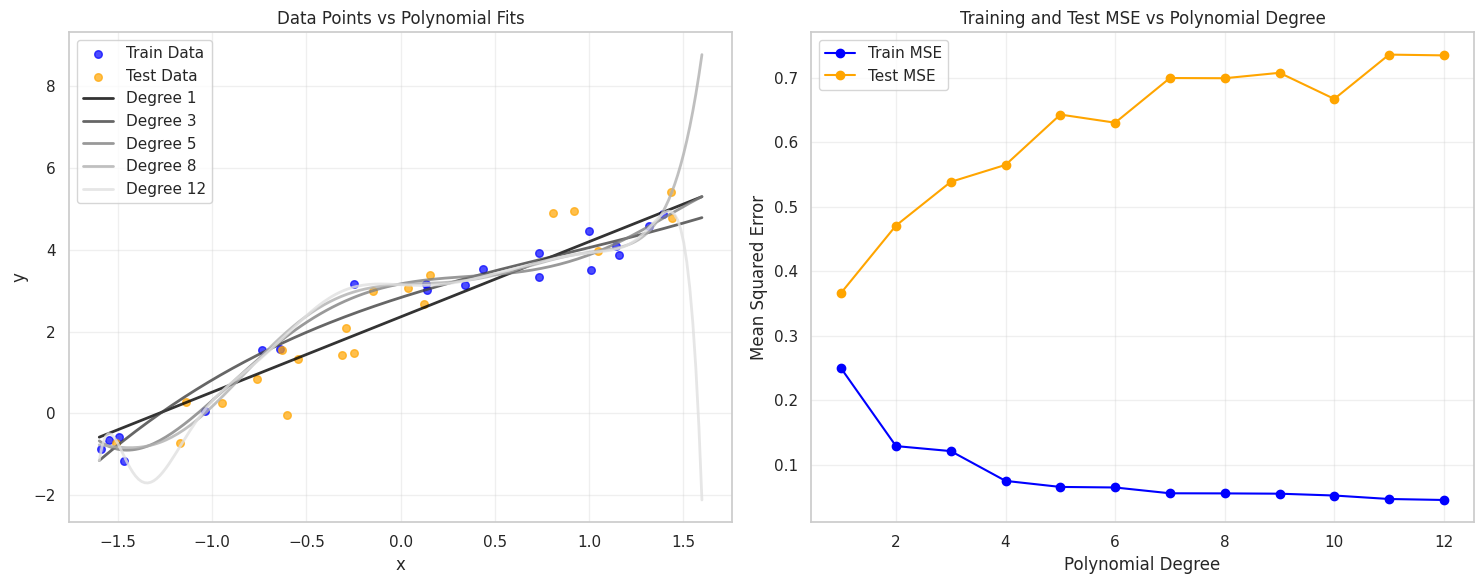

In [76]:
##### DO NOT CHANGE #####
# --- fitting models of different degrees ---

# Initialize lists to store MSE values for each degree
degrees = range(1, 13)
train_mse_list = []
test_mse_list = []

# Store fitted models for visualization
fitted_models = {}

# Fit polynomial models for degrees 1-12
for degree in degrees:
    # Create and fit polynomial model
    model = fit_polynomial_model(x_train_1d, y_train_1d, degree=degree)

    # Store the fitted model
    fitted_models[degree] = model

    # Predict on training and test data
    train_pred = model.predict(x_train_1d.reshape(-1, 1))
    test_pred = model.predict(x_test_1d.reshape(-1, 1))

    # Calculate MSE using sklearn's mean_squared_error
    train_mse = mean_squared_error(y_train_1d, train_pred)
    test_mse = mean_squared_error(y_test_1d, test_pred)

    # Store MSE values
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)

# Create two-panel plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: True function, data points, and polynomial fits
# Generate dense x range for smooth plotting
x_plot = np.linspace(X_MIN, X_MAX, 200)
y_true_plot = true_function_1d(x_plot)

# Plot true function
#ax1.plot(x_plot, y_true_plot, 'k--', linewidth=2, label='True Function', alpha=0.8)

# Plot training and test data
ax1.scatter(x_train_1d, y_train_1d, color='blue', alpha=0.7, s=30, label='Train Data')
ax1.scatter(x_test_1d, y_test_1d, color='orange', alpha=0.7, s=30, label='Test Data')

# Plot polynomial fits for selected degrees
selected_degrees = [1, 3, 5, 8, 12]
colors = ['#000000', '#404040', '#808080', '#B0B0B0', '#E0E0E0']

for i, degree in enumerate(selected_degrees):
    model = fitted_models[degree]
    y_pred_plot = model.predict(x_plot.reshape(-1, 1))
    ax1.plot(x_plot, y_pred_plot, color=colors[i], linewidth=2,
             label=f'Degree {degree}', alpha=0.8)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Data Points vs Polynomial Fits')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: MSE curves
ax2.plot(degrees, train_mse_list, 'b-o', label='Train MSE', color='blue')
ax2.plot(degrees, test_mse_list, 'o-', label='Test MSE', color='orange')
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('Mean Squared Error')
ax2.set_title('Training and Test MSE vs Polynomial Degree')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

**Out-of-Distribution Data.** Nun ist das zuvor beschriebene Overfitting nicht das einzige Phänomen dessen man sich bewusst sein sollte. Einen weiterer wichtiger Effekt kommt durch eine systematische Verschiebung in der Trainingsdatenverteilung zu stande. In vielen Anwendungen des maschinellen Lernens werden Trainingsdaten gesammelt um ein Modell fitten zu können welches danach ein bestimmtes Problem lösen soll. Als anschauliches Beispiel können wir ein Gesichtserkennungs-Modell betrachten: Ein solches Modell soll Gesichter auf Bildern erkennen um letztendlich zum Beispiel in einem Überwachungssystem verwendet zu werden. Um dieses Modell zu trainieren haben wir einen hochqualitativen Datensatz an Studio-Bildern zusammengetragen, trainieren ein Modell und evaluieren es erfolgreich auf den zuvor aufgeteilten Testdatenpunkten. Trotzdem ist es sehr wahrscheinlich dass ein solches Modell unseren Erwartungen in der realen Anwendung nicht gerecht wird. Der Hauptgrund hierfür ist dass die Bilder einer Überwachungskamera sich in vielen Aspekten stark von professionellen Studio-Bildern unterscheiden - es liegen komplett andere Blickwinkel, Belichtungszustände und Bildqualitäten vor. Letztendlich liegt eine große Diskrepanz zwischen der Trainingsdatenverteilung und der in Realität erwarteten Datenverteilung vor - viele reale Samples sind *out-of-distribution (OOD)*.

Im folgenden Abschnitt wollen wir diesen Aspekt genauer beleuchten. In den vorherigen Abschnitten wurde die gegebene wahre Funktion nur im Bereich $x \in [-1.5, 1.5]$ evaluiert. Obwohl wir Trainings- und Testdatensatz getrennt haben, sind sie auf diesen Bereich beschränkt. Im Folgenden wollen wir uns einen weiteren "Datensatz" ansehen welcher leicht außerhalb dieses Bereichs gesampled wurde.

<Axes: >

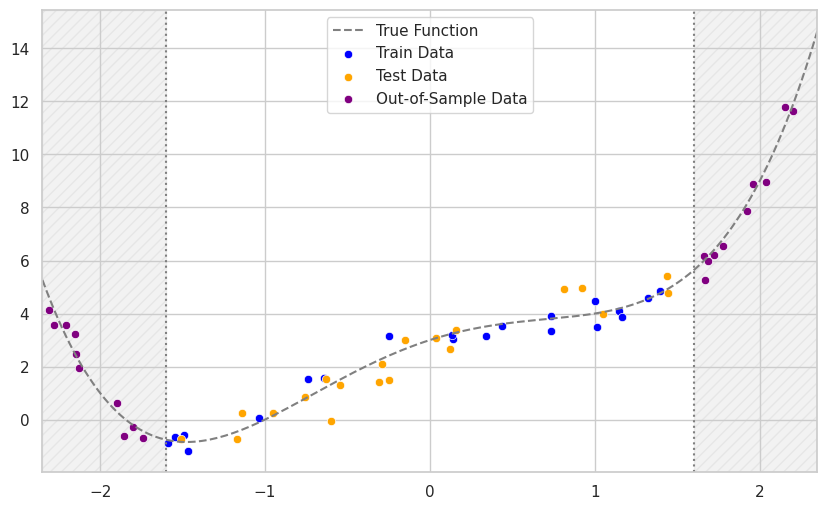

In [77]:
##### DO NOT CHANGE #####
DELTA = 0.75

xs_out_1d_left, ys_out_1d_left = generate_dataset_1d(num_samples=10, noise_std=0.75, seed=2, x_range=(X_MIN - DELTA, X_MIN))
xs_out_1d_right, ys_out_1d_right = generate_dataset_1d(num_samples=10, noise_std=0.75, seed=3, x_range=(X_MAX, X_MAX + DELTA))

xs_out_1d = np.concatenate([xs_out_1d_left, xs_out_1d_right])
ys_out_1d = np.concatenate([ys_out_1d_left, ys_out_1d_right])

# --- visualizing the true function outside of the training range ---

xs_true = np.linspace(X_MIN - DELTA, X_MAX + DELTA, 200)
ys_true = true_function_1d(xs_true)

plt.figure(figsize=(10, 6))
plt.xlim(X_MIN - DELTA, X_MAX + DELTA)

# Add background shading for out-of-distribution areas
plt.axvline(x=X_MIN, color='gray', linestyle=':')
plt.axvline(x=X_MAX, color='gray', linestyle=':')
plt.axvspan(X_MIN - DELTA, X_MIN, alpha=0.1, color='gray', hatch='///', zorder=0)
plt.axvspan(X_MAX, X_MAX + DELTA, alpha=0.1, color='gray', hatch='///', zorder=0)

# Plotting the true function and data points
plt.plot(xs_true, ys_true, label="True Function", color="gray", ls='--')
sns.scatterplot(x=x_train_1d, y=y_train_1d, label="Train Data", color="blue")
sns.scatterplot(x=x_test_1d, y=y_test_1d, label="Test Data", color="orange")
sns.scatterplot(x=xs_out_1d, y=ys_out_1d, label="Out-of-Sample Data", color="purple", marker="o")

##### DO NOT CHANGE #####

**📊 OOD Approximations Fehler.** Die folgende Visualisierung zeigt den gleichen Verlauf wie zuvor, für welchen Modelle mit steigendem Polynomgrad gefitted werden um deren entsprechenden Trainings- und Testfehler zu ermitteln. Allerdings wird in diesem Fall zusätzlich der Fehler auf dem zuvor gezeigten OOD Datensatz ebenfalls ermittelt (lila).

Zunächst können wir sehen dass der Fehler insgesamt *deutlich* höher ist. D.h. in einer realen Anwendung, die potentiell nicht strikt auf diesen Bereich beschränkt wäre, hätte uns der niedrige Testfehler in die Irre geführt. Noch wichtiger ist, dass wir einen anderen Verlauf über die verschiedenen Polynomgrade beobachten können. Für den Fall der OOD Daten kann man keine monotone Abnahme oder Zunahme mehr beobachten - viel mehr gibt es nun bestimmte Grade die Aufgrund der fortgeführten Form der Funktion deutlich besser geeignet sind als Andere.

/tmp/ipython-input-3432635660.py:38: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(degrees, train_mse_list, 'b-o', label='Train MSE', color='blue', ls='--')
/tmp/ipython-input-3432635660.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(degrees, train_mse_list, 'b-o', label='Train MSE', color='blue', ls='--')
/tmp/ipython-input-3432635660.py:39: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(degrees, test_mse_list, 'o-', label='Test MSE', color='orange', ls='--')


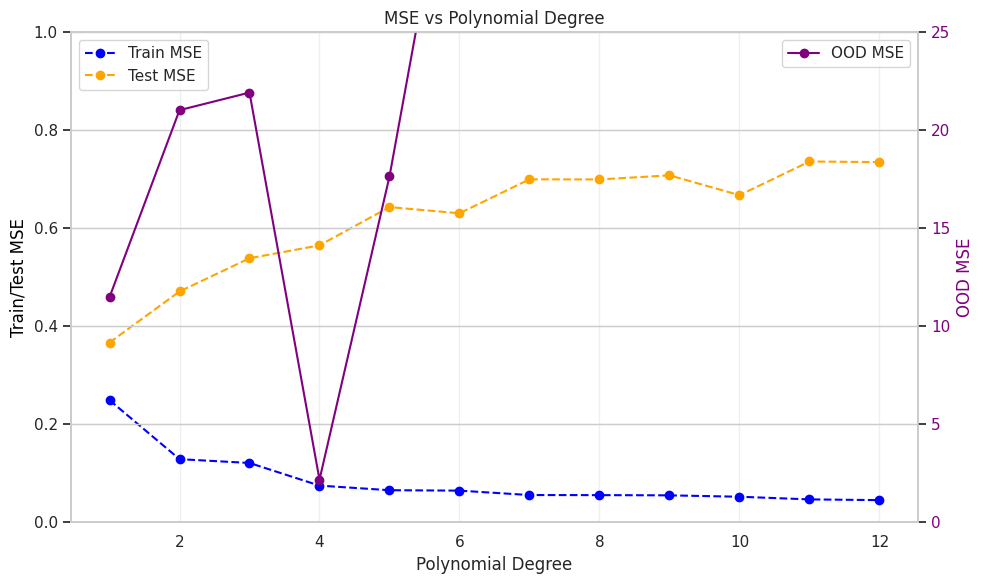

In [78]:
##### DO NOT CHANGE #####
# --- fitting models of different degrees ---

# Initialize lists to store MSE values for each degree
degrees = range(1, 13)
train_mse_list = []
test_mse_list = []
out_mse_list = []

# Fit polynomial models for degrees 1-12
for degree in degrees:
    # Create and fit polynomial model
    model = fit_polynomial_model(x_train_1d, y_train_1d, degree=degree)

    # Predict on training and test data
    train_pred = model.predict(x_train_1d.reshape(-1, 1))
    test_pred = model.predict(x_test_1d.reshape(-1, 1))
    out_pred = model.predict(xs_out_1d.reshape(-1, 1))

    # Calculate MSE using sklearn's mean_squared_error
    train_mse = mean_squared_error(y_train_1d, train_pred)
    test_mse = mean_squared_error(y_test_1d, test_pred)
    out_mse = mean_squared_error(ys_out_1d, out_pred)

    # Store MSE values
    train_mse_list.append(train_mse)
    test_mse_list.append(test_mse)
    out_mse_list.append(out_mse)

train_mse_list = np.array(train_mse_list)
test_mse_list = np.array(test_mse_list)
out_mse_list = np.array(out_mse_list)

# Plot the results with dual y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot train and test MSE on left y-axis
ax1.plot(degrees, train_mse_list, 'b-o', label='Train MSE', color='blue', ls='--')
ax1.plot(degrees, test_mse_list, 'o-', label='Test MSE', color='orange', ls='--')
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Train/Test MSE', color='black')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Create second y-axis for OOD MSE
ax2 = ax1.twinx()
ax2.plot(degrees, out_mse_list, 'o-', label='OOD MSE', color='purple')
ax2.set_ylabel('OOD MSE', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, 25)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('MSE vs Polynomial Degree')
plt.tight_layout()
plt.show()

##### DO NOT CHANGE #####

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.5 (1 Punkte).</strong> Welche Polynomordung sollte bestenfalls gewählt werden - basierend auf den <em>out-of-distribution</em> Daten, welche in einem realistischen Anwendungsfall zu erwarten sind? Weise die Antwort als Integer der Variable <code>polynomial_degree</code> zu.
</div>

In [79]:
polynomial_degree: int = None

# YOUR CODE HERE
polynomial_degree = 4

In [80]:
##### DO NOT CHANGE #####
# ID: task-2-5-poly-order - possible points: 1

assert isinstance(polynomial_degree, int), "The polynomial_degree variable should be an integer."
assert 1 <= polynomial_degree <= 12, "The polynomial_degree should be between 1 and 12."

# --- hidden tests ---
# The hidden tests will check if the selected polynomial degree is correct


##### DO NOT CHANGE #####

**Modell Evaluation.** Insgesamt soll dieses Beispiel verdeutlichen dass es sinnvoll ist sich Gedanken über eine sinnvolle Modell Evaluation zu machen. Die zufällige Aufteilung eines Datensatzes in Trainings- und Testdatenpunkte ist ein guter Anfang für eine Evaluation aber manchmal nicht ausreichend. Wie wir gesehen haben kann es sein dass ein zufälliger Testdatensatz zu Schlussfolgerungen fürht welche für eine reale Anwendung unter Umständen nicht optimal sind. In solchen Fällen kann man sich zum Beispiel überlegen zusätzliche Daten für eine Evaluation aufzutreiben, welche näher an der realen Anwendung liegen. Alternativ kann man sich auch eine bessere Teilungsstrategie für einen vorhandenen Datensatz überlegen anstatt zufällig aufzuteilen.

---

# **2.2** $\cdot$ *Klassifikation*

Im nächsten Teil der Aufgabe wollen wir uns mit Klassifikationsproblemen beschäftigen. Während es bei der Regression darum geht die Funktionswerte einer kontinuierlichen Funktion $f: \mathbb{R} \rightarrow \mathbb{R}$ zu approximieren, geht es bei der Klassifikation um Funktionen mit einem diskreten Wertebereich, welcher nur eine endliche Zahl von möglichen Funktionswerten annehmen kann, wie z.B. bei der binären Klassifikation $g: \mathbb{R} \rightarrow \{0, 1\}$.

Für die folgende Aufgabe nehmen wir das klassische Klassifikationsproblem des *Iris* Datensatzes unter die Lupe. Ziel des Datensatzes ist die Klassifikation der 3 verschiedenen Orchideen-Arten *iris setosa*, *iris versicolor* und *iris virginica* wie sie auch im Bild zu sehen sind. Hierzu wurde ein Datensatz aus verschiedenen Exemplaren dieser 3 Arten erstellt. Die Art wird dabei als zu approximierender Funktionswert $y$ herangezogen. Als Eingangsdaten werden jeweils die Längen und Breiten der verschiedenen Blattstrukturen (petal, sepal) angesehen - was heißt dass insgesamt 4 Werte zur Klassifikation zur Verfügung stehen. Das heißt es geht darum folgende Funktion zu approximieren.

$$
h: \mathbb{R}^4 \rightarrow \{setosa, versicolor, virginica\}
$$

Um mit dieser Aufgabe zu beginnen laden wir uns zunächst den Datensatz herunter und vergewissern uns wie dieser aufgebaut ist.

<img src="https://k3-production-bucket.s3.amazonaws.com/uploads/cD6ccKKMJJW8rENfe_51518iris%20img1.png">

In [81]:
##### DO NOT CHANGE #####
print(' * downloading the dataset from nextcloud ...')
csv_content: str = nextcloud_download('https://bwsyncandshare.kit.edu/s/gXRcRWiza69qEjy')

data_frame = pd.read_csv(io.StringIO(csv_content))
print(f' * dataset with {len(data_frame)} entries')
data_frame.head()

##### DO NOT CHANGE #####

 * downloading the dataset from nextcloud ...
 * dataset with 150 entries


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Den Datensatz, der momentan in der Form einer pandas `DataFrame` vorliegt, müssen wir zunächst in die entsprechenden Matritzen $\mathbf{X}$ und $\mathbf{y}$ umwandeln. Nachdem wir die Daten umgewandelt haben, können wir den Datensatz auch in Trainings- und Testdatenpunkte aufteilen. Hierzu nutzen wir eine gängige Aufteilung von 80 zu 20.

In [82]:
##### DO NOT CHANGE #####
x_cls = data_frame[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].to_numpy()
# Note: y_cls will be a string array containing species names like 'Iris-setosa', 'Iris-versicolor', etc.
# Scikit-learn models can handle string labels directly - they automatically encode them internally
# to numeric values during training. This is more convenient than manually converting to integers
# or one-hot encoding beforehand.
y_cls = data_frame[['Species']].to_numpy()

x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(
    x_cls,
    y_cls,
    test_size=0.2,
    random_state=0,
)

##### DO NOT CHANGE #####

## **2.2.1** $\cdot$ *Logistische Regression*

Um das beschriebene Klassifikationsproblem zu lösen wollen wir *logistische Regression* nutzen, welche ebenfalls in `scikit-learn` implementiert ist. Während lineare Regression kontinuierliche Werte vorhersagt, transformiert logistische Regression die Ausgabe einer linearen Funktion in eine Wahrscheinlichkeit zwischen 0 und 1. Dies macht sie besonders geeignet für Klassifikationsaufgaben.

**Mathematische Grundlagen.** Für die binäre Klassifikation nutzt logistische Regression die *Sigmoid-Funktion* (auch logistische Funktion genannt) um die Ausgabe einer linearen Funktion auf das Intervall $[0, 1]$ abzubilden:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Für eine Eingabe $\mathbf{x}$ wird zunächst eine gewichtete Linearkombination berechnet $z = \mathbf{w}^T \mathbf{x} + b$ und anschließend durch die Sigmoid-Funktion transformiert. Das Ergebnis kann als Wahrscheinlichkeit für die Klassenzugehörigkeit interpretiert werden:

$$
P(y=1 | \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x} + b)}}
$$

**Multi-Class Klassifikation.** Für Probleme mit mehr als zwei Klassen - wie im Fall des Iris-Datensatzes mit drei verschiedenen Arten - wird logistische Regression auf mehrere Klassen erweitert. Ein gängiger Ansatz ist die *Softmax-Regression* (auch multinomiale logistische Regression genannt), welche für jede Klasse $k$ eine Wahrscheinlichkeit berechnet:

$$
P(y=k | \mathbf{x}) = \frac{e^{\mathbf{w}_k^T \mathbf{x}}}{\sum_{j=1}^{K} e^{\mathbf{w}_j^T \mathbf{x}}}
$$

Hierbei wird für jede der $K$ Klassen ein eigener Gewichtsvektor $\mathbf{w}_k$ gelernt. Die Klasse mit der höchsten Wahrscheinlichkeit wird als finale Vorhersage gewählt.

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.6 (2 Punkte).</strong> Instanziere eine neue Instanz der <code>LogisticRegression</code> Klasse in der unten ausgewiesenen Variable <code>logistic_model</code> und fitte dieses auf den gegebenen Trainingsdaten. <em>Hinweis:</em> Die versteckten Tests prüfen auf eine Mindestgenauigkeit von 70%. Daher kann es Sinn machen neben dem fitting des Modells auch die Testgenauigkeit ausgeben zu lassen um sicherzustellen dass die erwartete Genauigkeit erreicht wird.
</div>

In [83]:
logistic_model: LogisticRegression = None

# YOUR CODE HERE
logistic_model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,  # stellt sicher, dass das Modell konvergiert
    random_state=0
)
logistic_model.fit(x_train_cls, y_train_cls.ravel())

# Optional: Testgenauigkeit ausgeben
y_pred_cls = logistic_model.predict(x_test_cls)
accuracy = accuracy_score(y_test_cls, y_pred_cls)
print(f" * Test Accuracy: {accuracy:.4f}")

 * Test Accuracy: 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [84]:
##### DO NOT CHANGE #####
# ID: task-2-6-cls-fit - possible points: 2

# --- checking type ---
assert logistic_model is not None, "You have to initialize the logistic_model variable with a LogisticRegression model and fit it on the training data."
assert isinstance(logistic_model, LogisticRegression), "The logistic_model variable has to be of type LogisticRegression."
assert hasattr(logistic_model, "coef_"), "The model has not been fitted yet. Please fit the model on the training data."

# --- hidden tests ---
# Checking if the model is fitted correctly by evaluating its performance on the test set to
# be at least 70% accuracy


##### DO NOT CHANGE #####

In [85]:
##### DO NOT CHANGE #####
# --- evaluating the model on test set ---
y_pred_cls = logistic_model.predict(x_test_cls)
acc_value = accuracy_score(y_test_cls, y_pred_cls)
print(f' * Accuracy on the test set: {acc_value:.4f}')


##### DO NOT CHANGE #####

 * Accuracy on the test set: 1.0000


**Confusion Matrix.** Eine *Confusion Matrix* (Verwechslungsmatrix) ist ein wichtiges Werkzeug zur Evaluation von Klassifikationsmodellen. Sie stellt die vorhergesagten Klassen den tatsächlichen Klassen gegenüber: Elemente auf der Diagonalen repräsentieren korrekte Vorhersagen, während Einträge außerhalb der Diagonalen Fehlklassifikationen darstellen.

Unabhängig von einem einzelnen Wert zur Modellgenauigkeit hilft eine solche Darstellung herauszufinden ob es bestimmte Kombinationen an Klassen gibt mit welchen das Problem besondere Probleme hat.

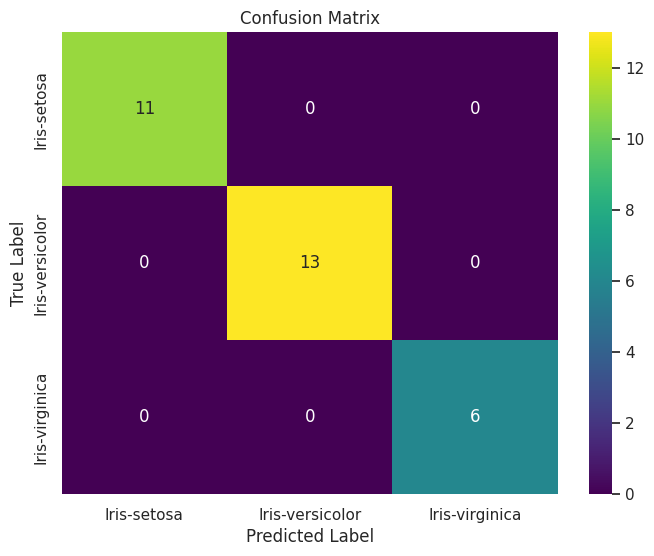

In [86]:
##### DO NOT CHANGE #####

# --- creating confusion matrix ---
conf_matrix = sklearn.metrics.confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=logistic_model.classes_,
            yticklabels=logistic_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### DO NOT CHANGE #####

**Decision Boundary.** Im nächsten Schritt würden wir gerne die *decision boundary* unseres Klassifikationsmodells visualisieren. Dies beschreibt ein Diagramm wobei die Achsen die Eingangswerte des Modells darstellen und die Bereiche zeigen, welche Klasse das Modell für jeden Punkt im Eingaberaum vorhersagen würde.

**Dimensionalitätsreduktion.** Für die gegebene Klassifikationsaufgabe ergibt sich dass Problem dass es sich um eine Funktion mit 4 Eingangswerten handelt und es notorisch schwer ist eine 4-dimensionale Funktion sinnvoll zu visualisieren. Eine Möglichkeit wäre mehrere verschiedene 2D-Diagramme zu erstellen welche verschiedene paarweise Kombinationen der Eingangswerte abdecken. Eine andere Möglichkeit, welche in solchen Fällen oft genutzt wird, ist eine *Dimensionalitätsreduktion* durchzuführen. Hierbei handelt es sich um eine Koordinatentransformation wobei die ursprünglichen 4 Koordinaten auf lediglich 2 Variablen zurückgeführt werden. Dabei wird jene Transformation gesucht welche zu einem möglichst geringen Informationsverlust führt.

Eine häufig verwendete Methode zur Dimensionalitätsreduktion ist die *Principle Component Analysis (PCA)*. Dies ist eine *lineare* Projektion der ursprünglichen Koordinaten in einen niederdimensionalen Raum, wobei versucht wird die Varianz der Datenpunkte im reduzierten Raum zu maximieren.

<img src="https://lh6.googleusercontent.com/proxy/5FoHrYaHli1iqNXZunq4wg9GrHhZJFfUlRYrBLpxOXLd1R7b9a8Hkk_uukWQbLTWlvmnq07l6yypWJXBZXDbdfbq5uOrc7e32I4AdrCezl4">

Im Folgenden fürhen wir eine solche PCA durch um die Dimensionalität der Eingangsdaten von 4 auf 2 (einfach visualisierbar) zu reduzieren.

In [87]:
##### DO NOT CHANGE #####
reducer = PCA(n_components=2)
x_reduced = reducer.fit_transform(x_cls)
print(f' * dimensionality reduced from {x_cls.shape[1]} to {x_reduced.shape[1]} dimensions')

##### DO NOT CHANGE #####

 * dimensionality reduced from 4 to 2 dimensions


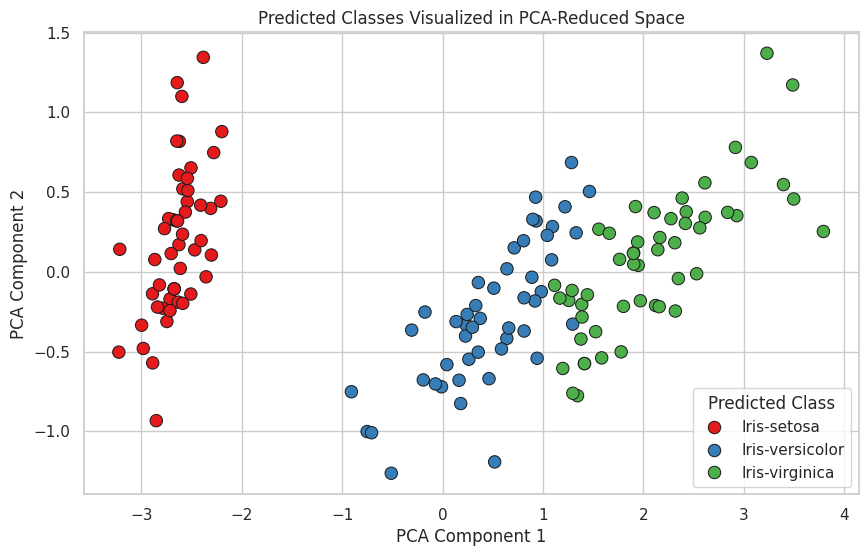

In [88]:
# YOUR CODE HERE
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=x_reduced[:, 0],
    y=x_reduced[:, 1],
    hue=logistic_model.predict(x_cls),        # color by predicted class
    palette="Set1",                           # nice distinct colors
    s=80,
    edgecolor="k"
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Predicted Classes Visualized in PCA-Reduced Space")
plt.legend(title="Predicted Class")
plt.show()

**📊 Decision Boundary.** Das unten gezeigte Diagramm stellt die Entscheidungsgrenze des zuvor trainierten logistischen Regressionsmodells dar. Hierbei werden zunächst die Datenpunkte des Testdatensatzes durch die PCA auf die transformierten Koordinaten projiziert und mit verschiedenen Farben im Diagramm eingetragen. Die Sättigung der Hintergrundfarbe zeigt die confidence des Klassifikationsmodells and der entsprechenden Stelle an. Volle Farbsättigung impliziert eine 100%-ige Klassifikationswahrscheinlichkeit für die der Farbe entsprechende Klasse. Weiße Bereiche markieren die Entscheidungsgrenze zwischen zwei Klassen.

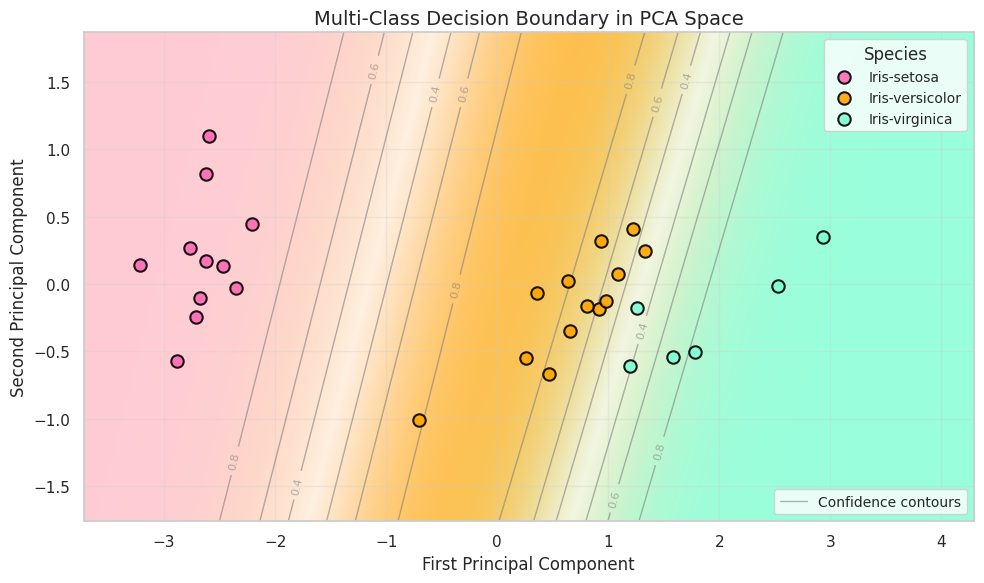

In [89]:
##### DO NOT CHANGE #####
# --- plot the decision boundary based on PCA dimensions ---

# Create a mesh grid in the 2D PCA space
x_min, x_max = x_reduced[:, 0].min() - 0.5, x_reduced[:, 0].max() + 0.5
y_min, y_max = x_reduced[:, 1].min() - 0.5, x_reduced[:, 1].max() + 0.5

# Create a fine mesh grid for smooth decision boundary
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Transform grid points back to original 4D space using inverse PCA
grid_points_2d = np.c_[xx.ravel(), yy.ravel()]
grid_points_4d = reducer.inverse_transform(grid_points_2d)

# Get decision probabilities for all classes from the logistic regression model
decision_probs = logistic_model.predict_proba(grid_points_4d)

# Define class colors as RGB values: pink, orange, aquamarine
class_colors_rgb = np.array([
    [1.0, 0.75, 0.8],    # hotpink
    [1.0, 0.65, 0.0],    # orange
    [0.5, 1.0, 0.83]     # aquamarine
])

# Create color mixing function
def create_multiclass_colors(probs, class_colors):
    """
    Create RGB colors by mixing class colors based on probabilities.
    Areas with uncertain predictions (equal probs) will be white.
    Areas with high confidence will show saturated class colors.
    """
    # Calculate confidence as deviation from uniform distribution
    uniform_prob = 1.0 / probs.shape[1]  # 1/3 for 3 classes
    max_prob = np.max(probs, axis=1)
    confidence = (max_prob - uniform_prob) / (1.0 - uniform_prob)

    # Weight colors by probabilities
    rgb_colors = np.dot(probs, class_colors)

    # Blend with white based on confidence
    # Low confidence -> white, high confidence -> class color
    white = np.array([1.0, 1.0, 1.0])
    final_colors = confidence[:, np.newaxis] * rgb_colors + (1 - confidence[:, np.newaxis]) * white

    # Ensure values are in [0, 1] range
    final_colors = np.clip(final_colors, 0, 1)

    return final_colors.reshape(xx.shape[0], xx.shape[1], 3)

# Create the multi-class color map
multiclass_colors = create_multiclass_colors(decision_probs, class_colors_rgb)

# Calculate confidence for contour lines
uniform_prob = 1.0 / 3
max_probs = np.max(decision_probs, axis=1)
confidence_grid = ((max_probs - uniform_prob) / (1.0 - uniform_prob)).reshape(xx.shape)

# Transform test set to PCA space for plotting
x_test_reduced = reducer.transform(x_test_cls)

# Define class colors for scatter plot
class_colors = ['hotpink', 'orange', 'aquamarine']
class_names = logistic_model.classes_

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the multi-class decision boundary using imshow for the color mixing
plt.imshow(multiclass_colors, extent=[x_min, x_max, y_min, y_max],
           origin='lower', alpha=0.8, aspect='auto')

# Add discrete confidence contour lines
confidence_levels = [0.2, 0.4, 0.6, 0.8]
contour_lines = plt.contour(xx, yy, confidence_grid, levels=confidence_levels,
                           colors='gray', alpha=0.6, linewidths=1)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f')

# Plot the projected test set with custom colors
for i, class_name in enumerate(class_names):
    # Get indices for this class
    class_mask = (y_test_cls.ravel() == class_name)
    plt.scatter(x_test_reduced[class_mask, 0],
               x_test_reduced[class_mask, 1],
               c=class_colors[i],
               s=80,
               alpha=0.9,
               edgecolors='black',
               linewidth=1.5,
               label=class_name,
               zorder=5)

# Set labels and title
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Multi-Class Decision Boundary in PCA Space',
          fontsize=14)

# Create custom legend
legend1 = plt.legend(title='Species', loc='upper right', fontsize=10)
plt.gca().add_artist(legend1)

# Add confidence legend
from matplotlib.lines import Line2D
confidence_legend_elements = [Line2D([0], [0], color='gray', alpha=0.6, linewidth=1,
                                   label='Confidence contours')]
legend2 = plt.legend(handles=confidence_legend_elements, loc='lower right', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


##### DO NOT CHANGE #####

<div style="border: 1px solid #CEB037; border-radius: 3px; padding: 6px; background-color: #faf7e0ff; color: black;">
<strong>🛠️ Aufgabe 2.8 (1 Bonuspunkt).</strong> Im obigen Plot sind die decision boundaries des logistischen Regressionsmodells dargestellt, welches gefitted wurde um das Iris-Klassifikationsproblem zu lösen. Die Entscheidungsgrenzen erscheinen momentan als gerade Linien. Weise der unten stehenden Variable <code>answer</code> einen boolschen Wert zu um folgende Frage zu beantworten: Wäre es möglich bei gleichem Modell (logistische Regression) und gleicher Projektion (PCA) aber bei beliebig anderen Daten gekrümmte (nicht gerade) Entscheidungsgrenzen zu sehen?
<em>Hinweis:</em> Bonuspunkteaufgaben tragen nicht zur Maximalpunkteanzahl eines Übungsblattes bei.</em>
</div>

In [90]:
# True -> curved decision boundaries would be possible
# False -> decision boundaries will always be straight
answer: bool = None

# YOUR CODE HERE
answer = False

In [91]:
##### DO NOT CHANGE #####
# ID: task-2-8-decision-bound - possible points: 1

# --- hidden tests ---
# The hidden tests will check if the answer is correct

assert answer is not None, "You have to set the answer variable to either True or False."
assert isinstance(answer, bool), "The answer variable should be a boolean (True or False)."


##### DO NOT CHANGE #####

## Zusammenfassung und Reflexion

In diesem Übungsblatt haben Sie sich mit den grundlegenden Konzepten der **Regression** und **Klassifikation** vertraut gemacht. Sie haben lineare Modelle von Grund auf implementiert, deren Grenzen kennengelernt und gelernt, wie man sie mit Hilfe von scikit-learn effizient einsetzt.

**Was Sie gelernt haben:**

- **Lineare Regression**: Implementierung der Ordinary Least Squares Methode über die Pseudo-Inverse, um kontinuierliche Funktionen zu approximieren.
- **Train-Test Aufteilung**: Die Bedeutung der Trennung von Trainings- und Testdaten zur Bewertung der Modellgeneralisierung.
- **Overfitting**: Wie komplexere Modelle (höhere Polynomgrade) zu besserer Anpassung an Trainingsdaten führen können, aber gleichzeitig schlechtere Vorhersagen auf neuen Daten liefern.
- **Out-of-Distribution Daten**: Die Herausforderung, dass Modelle auf Daten außerhalb des Trainingsbereichs oft schlecht performen, selbst wenn der Testfehler niedrig ist.
- **Polynom-Regression**: Erweiterung linearer Modelle durch Transformation der Eingabefeatures, um nicht-lineare Funktionen zu approximieren.
- **Logistische Regression**: Ein lineares Modell für Klassifikationsaufgaben, das Wahrscheinlichkeiten für Klassenzugehörigkeiten vorhersagt.
- **Multi-Class Klassifikation**: Erweiterung der binären Klassifikation auf mehrere Klassen mittels Softmax-Regression.
- **Dimensionalitätsreduktion**: Verwendung von PCA zur Visualisierung hochdimensionaler Entscheidungsgrenzen in 2D.

**Wichtige Erkenntnisse:**

1. **Modellkomplexität vs. Generalisierung**: Ein Modell sollte komplex genug sein, um die zugrunde liegende Funktion zu erfassen, aber nicht so komplex, dass es Rauschen lernt.
2. **Evaluation ist entscheidend**: Die Art und Weise, wie Sie Ihr Modell evaluieren (zufällige Train-Test-Splits, OOD-Daten, Cross-Validation), hat großen Einfluss darauf, wie gut Ihre Schlussfolgerungen für reale Anwendungen sind.

Dies ist das Ende des Übungsblattes. Bitte vergessen Sie nicht das Notebook vor der Abgabe einmal komplett von vorne durchlaufen zu lassen um auf mögliche Fehler zu prüfen. **Und denken sie insbesondere daran den handschriftlichen Teil der Übung ebenfalls, in PDF Format, hochzuladen.**

---